## TS 그룹별 모델 종합 성능 평가 스크립트

**목표:** `lowTS`, `midTS`, `highTS` 그룹별로 개별 학습된 모델들을 모두 로드하여, 전체 데이터셋에 대한 예측 성능을 한 번에 종합하고 시각화합니다.

**프로세스:**
1. **설정 및 정의:** 필요한 라이브러리, 경로, 하이퍼파라미터, 핵심 함수들을 정의합니다.
2. **모델/스케일러 로딩:** 3개 그룹의 모델(`*.pth`)과 스케일러(`*.pkl`)를 모두 불러옵니다.
3. **데이터 로딩 및 전처리:** 전체 데이터셋을 불러와 학습 시와 동일한 기준으로 정제합니다.
4. **그룹별 예측 및 취합:** 데이터를 TS 기준으로 나누어 각각에 맞는 모델로 예측을 수행하고, 결과를 하나로 합칩니다.
5. **종합 평가 및 시각화:** 전체 데이터에 대한 최종 피로 수명(`2Nf`) 산점도를 생성하고 성능 지표를 계산합니다.

In [2]:
# Cell 1: 라이브러리 임포트 및 기본 설정
# =============================================================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# --- 기본 설정값 ---
# [사용자 수정 필요] 데이터 경로
data_path = "TrainSet0507_NoDuplicatesHV.xlsx" #TrainSetMMS, TrainSet0507_NoDuplicatesHV

# [사용자 수정 필요] 모델 및 스케일러가 저장된 디렉토리 경로
asset_dir = './'

# TS 분류 기준
TS_LOW_THRESHOLD = 750
TS_MID_THRESHOLD = 1030

# 그룹 정의
groups = ['lowTS', 'midTS', 'highTS']

# 장치 설정
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: mps


In [3]:
# Cell 2: 모델 클래스 및 핵심 함수 정의
# =============================================================================

# 1. PyTorch 모델 클래스 정의
class FatiguePINN(nn.Module):
    def __init__(self, input_dim, output_dim, n_layers, hidden_dims, dropout_rate):
        super(FatiguePINN, self).__init__()
        layers = []
        current_dim = input_dim
        for i in range(n_layers):
            layers.append(nn.Linear(current_dim, hidden_dims[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            current_dim = hidden_dims[i]
        layers.append(nn.Linear(current_dim, output_dim))
        
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# 2. 피로 수명 계산 함수 (Coffin-Manson 역계산) - HighTS 노트북 로직 적용
def solve_2Nf_from_strain(params, E, strain_amplitude):
    spf, b, epf, c = params
    
    # 비물리적 값에 대한 기본 방어
    if E <= 0 or spf <= 0:
        return np.nan
        
    two_Nf_candidates = np.logspace(1, 16, 300)
    
    try:
        # 탄성 항 계산
        elastic_strain = (spf / E) * (two_Nf_candidates)**b
        
        # [수정됨] epf가 음수이면 소성 항을 0으로 처리 (참고 노트북 핵심 로직)
        if epf < 0:
            plastic_strain = 0
        else:
            plastic_strain = epf * (two_Nf_candidates)**c
            
        estimated_strain = elastic_strain + plastic_strain
        
        if np.any(np.isnan(estimated_strain)) or np.any(np.isinf(estimated_strain)):
            return np.nan
    except (OverflowError, ValueError):
        return np.nan

    idx = np.argmin(np.abs(estimated_strain - strain_amplitude))
    
    # 수렴하지 않는 경우(경계값 선택)를 NaN으로 처리
    if idx == 0 or idx == len(two_Nf_candidates) - 1:
        return np.nan
    return two_Nf_candidates[idx]


# 3. 타겟 변수 역변환 함수
def inverse_transform_targets(y_scaled, scalers_dict, target_cols, device='cpu'):
    y_scaled_np = y_scaled.detach().cpu().numpy() if isinstance(y_scaled, torch.Tensor) else y_scaled
    y_inv = np.zeros_like(y_scaled_np)
    scalers = scalers_dict['scalers']
    log_col_name = 'epf'
    for i, col_name in enumerate(target_cols):
        val_col = y_scaled_np[:, i].reshape(-1, 1)
        inv_val = scalers[col_name].inverse_transform(val_col)
        if col_name == log_col_name:
            inv_val = np.expm1(inv_val)
        y_inv[:, i] = inv_val.flatten()
    return pd.DataFrame(y_inv, columns=target_cols)

# 4. 그룹별 하이퍼파라미터 딕셔너리
params_dict = {
    'lowTS': {'n_layers': 3, 'hidden_dims': [186, 294, 64], 'dropout': 0.2153585570737508},
    'midTS': {'n_layers': 6, 'hidden_dims': [304, 451, 275, 421, 286, 232], 'dropout': 0.20153194157945667},
    'highTS': {'n_layers': 4, 'hidden_dims': [199, 324, 330, 215], 'dropout': 0.3165009134622956}
}



In [4]:
# Cell 3: 모델 및 스케일러 로딩
# =============================================================================

models, scalers_X, scalers_y = {}, {}, {}
input_dim, output_dim = 4, 4

print("Loading models and scalers for each group...")
for group in groups:
    try:
        params = params_dict[group]
        model = FatiguePINN(input_dim, output_dim, params['n_layers'], params['hidden_dims'], params['dropout']).to(device)
        model_path = os.path.join(asset_dir, f'model_{group}.pth')
        scaler_X_path = os.path.join(asset_dir, f'scaler_X_{group}.pkl')
        scaler_y_path = os.path.join(asset_dir, f'scalers_y_{group}.pkl')
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        models[group] = model
        scalers_X[group] = joblib.load(scaler_X_path)
        scalers_y[group] = joblib.load(scaler_y_path)
        print(f"- [{group}] group model and scalers loaded successfully!")
    except FileNotFoundError as e:
        print(f"- [ERROR] Could not find file for group {group}: {e.filename}")
        print("  >> Please check file names or the asset_dir path.")
        models = {}
        break
if models:
    print("\nAll models and scalers loaded.")



Loading models and scalers for each group...
- [lowTS] group model and scalers loaded successfully!
- [midTS] group model and scalers loaded successfully!
- [highTS] group model and scalers loaded successfully!

All models and scalers loaded.


In [5]:
# Cell 4: 전체 데이터 로딩 및 학습과 동일한 전처리 수행
# =============================================================================

try:
    # 이전에 성공했으므로 'Tensile' 시트 이름을 유지합니다.
    df_raw = pd.read_excel(data_path, sheet_name='Tensile')
    print(f"Data loaded successfully. Initial number of records: {len(df_raw)}")
    
    # [수정 1] Excel 파일의 실제 컬럼 이름과 일치하도록 매핑을 수정합니다.
    # 원본 학습 노트북(main0527)과 동일한 전처리 과정을 보장하기 위함입니다.
    column_mapping = {
        'E': 'E_GPa', 
        'YS': 'YS_MPa', 
        'TS': 'TS_MPa', 
        'HB': 'HB', 
        'HV': 'HV',
        'sf': 'spf_MPa',
        'b': 'b',
        'ef': 'epf',
        'c': 'c'
    }
    # 만약 위 이름이 정확하지 않다면, 주석을 해제하여 실제 컬럼명을 확인하고 수정해주세요.
    # print("실제 엑셀 컬럼명:", df_raw.columns)
    df = df_raw.rename(columns=column_mapping)

    # [수정 2] E를 GPa에서 MPa로 변환하는 단계를 추가합니다.
    # 이 과정이 누락되면 E 값이 1000배 작게 계산되어 2Nf 계산이 실패합니다.
    if 'E_GPa' in df.columns:
        df['E_MPa'] = df['E_GPa'] * 1000
        print("E_GPa has been converted to E_MPa (multiplied by 1000).")
    else:
        if 'E_MPa' not in df.columns:
             raise KeyError("Neither 'E_GPa' nor 'E_MPa' found after mapping. Check column_mapping.")
        else:
             print("Using existing E_MPa column.")

    # 이제 'E_MPa'를 사용합니다.
    target_cols_renamed = ['spf_MPa', 'b', 'epf', 'c']
    
    # 숫자형 변환
    numeric_cols_to_check = ['E_MPa', 'YS_MPa', 'TS_MPa', 'HB', 'HV', 'spf_MPa', 'b', 'epf', 'c']
    cols_to_convert = [col for col in numeric_cols_to_check if col in df.columns]
    for col in cols_to_convert:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # 이후 전처리 과정은 이전과 동일합니다.
    df_cleaned = df.dropna(subset=target_cols_renamed).copy()
    print(f"Records after dropping NaN in targets: {len(df_cleaned)}")

    if 'HB' in df_cleaned.columns and 'HV' in df_cleaned.columns:
        hb_missing_mask = df_cleaned['HB'].isnull() & df_cleaned['HV'].notnull()
        df_cleaned.loc[hb_missing_mask, 'HB'] = df_cleaned.loc[hb_missing_mask, 'HV'] * 0.95
    
    df_cleaned = df_cleaned.rename(columns={'HB': 'HB_processed'})
    
    # 특성 컬럼에 'E_MPa'가 포함되도록 확인
    feature_cols = ['E_MPa', 'YS_MPa', 'TS_MPa', 'HB_processed']

    df_cleaned = df_cleaned.dropna(subset=feature_cols)
    df_cleaned.reset_index(drop=True, inplace=True)
    print(f"Final number of records after preprocessing: {len(df_cleaned)}")
    
except FileNotFoundError:
    print(f"[ERROR] Data file not found at: {data_path}")
    df_cleaned = pd.DataFrame()
except Exception as e:
    print(f"[ERROR] An error occurred during data processing in Cell 4: {e}")
    df_cleaned = pd.DataFrame()

Data loaded successfully. Initial number of records: 934
E_GPa has been converted to E_MPa (multiplied by 1000).
Records after dropping NaN in targets: 918
Final number of records after preprocessing: 649


In [6]:
# Cell 5: 그룹별 예측 수행 및 결과 취합
# =============================================================================

target_cols = ['spf_MPa', 'b', 'epf', 'c']

if 'df_cleaned' in locals() and not df_cleaned.empty and models:
    df_results = df_cleaned.copy()
    
    pred_cols = [f'{col}_pred' for col in target_cols]
    for col in pred_cols:
        df_results[col] = np.nan
    
    print("\nStarting prediction for each group...")
    for group in groups:
        if group == 'lowTS':
            mask = (df_results['TS_MPa'] < TS_LOW_THRESHOLD)
        elif group == 'midTS':
            mask = (df_results['TS_MPa'] >= TS_LOW_THRESHOLD) & (df_results['TS_MPa'] < TS_MID_THRESHOLD)
        else:
            mask = (df_results['TS_MPa'] >= TS_MID_THRESHOLD)
        
        if not mask.any():
            print(f"- No data for group [{group}]. Skipping.")
            continue

        print(f"- Processing group [{group}]... ({mask.sum()} records)")
        
        X_group = df_results.loc[mask, feature_cols].values
        X_group_scaled = scalers_X[group].transform(X_group)
        X_group_tensor = torch.FloatTensor(X_group_scaled).to(device)
        
        with torch.no_grad():
            pred_scaled = models[group](X_group_tensor)
        
        y_target_cols = scalers_y[group]['target_cols'] 
        df_pred_inv = inverse_transform_targets(pred_scaled, scalers_y[group], y_target_cols, device)
        
        df_results.loc[mask, pred_cols] = df_pred_inv.values

    print("\nPrediction and result aggregation complete.")
    print(df_results[target_cols + pred_cols].head())
else:
    print("Could not proceed with prediction due to data or model loading failure.")




Starting prediction for each group...
- Processing group [lowTS]... (208 records)
- Processing group [midTS]... (215 records)
- Processing group [highTS]... (226 records)

Prediction and result aggregation complete.
   spf_MPa      b    epf      c  spf_MPa_pred    b_pred  epf_pred    c_pred
0    829.0 -0.129  0.246 -0.492    787.915955 -0.121693  0.412644 -0.506726
1    832.0 -0.122  0.450 -0.534    813.048584 -0.121153  0.411806 -0.506696
2    872.0 -0.134  0.271 -0.503    788.650635 -0.119938  0.414319 -0.507468
3    483.0 -0.079  0.215 -0.450    814.729370 -0.118484  0.414405 -0.508058
4    538.0 -0.073  0.110 -0.410    944.024353 -0.111278  0.393978 -0.499633



Calculating final fatigue life (2Nf) and visualizing overall performance...
Using fixed total strain amplitudes (Δε/2 or ε_a) for evaluation: [0.0025 0.003  0.0035 0.004  0.0045 0.005  0.009  0.015 ]
Filtered to 5033 (exp, est) pairs for plotting.


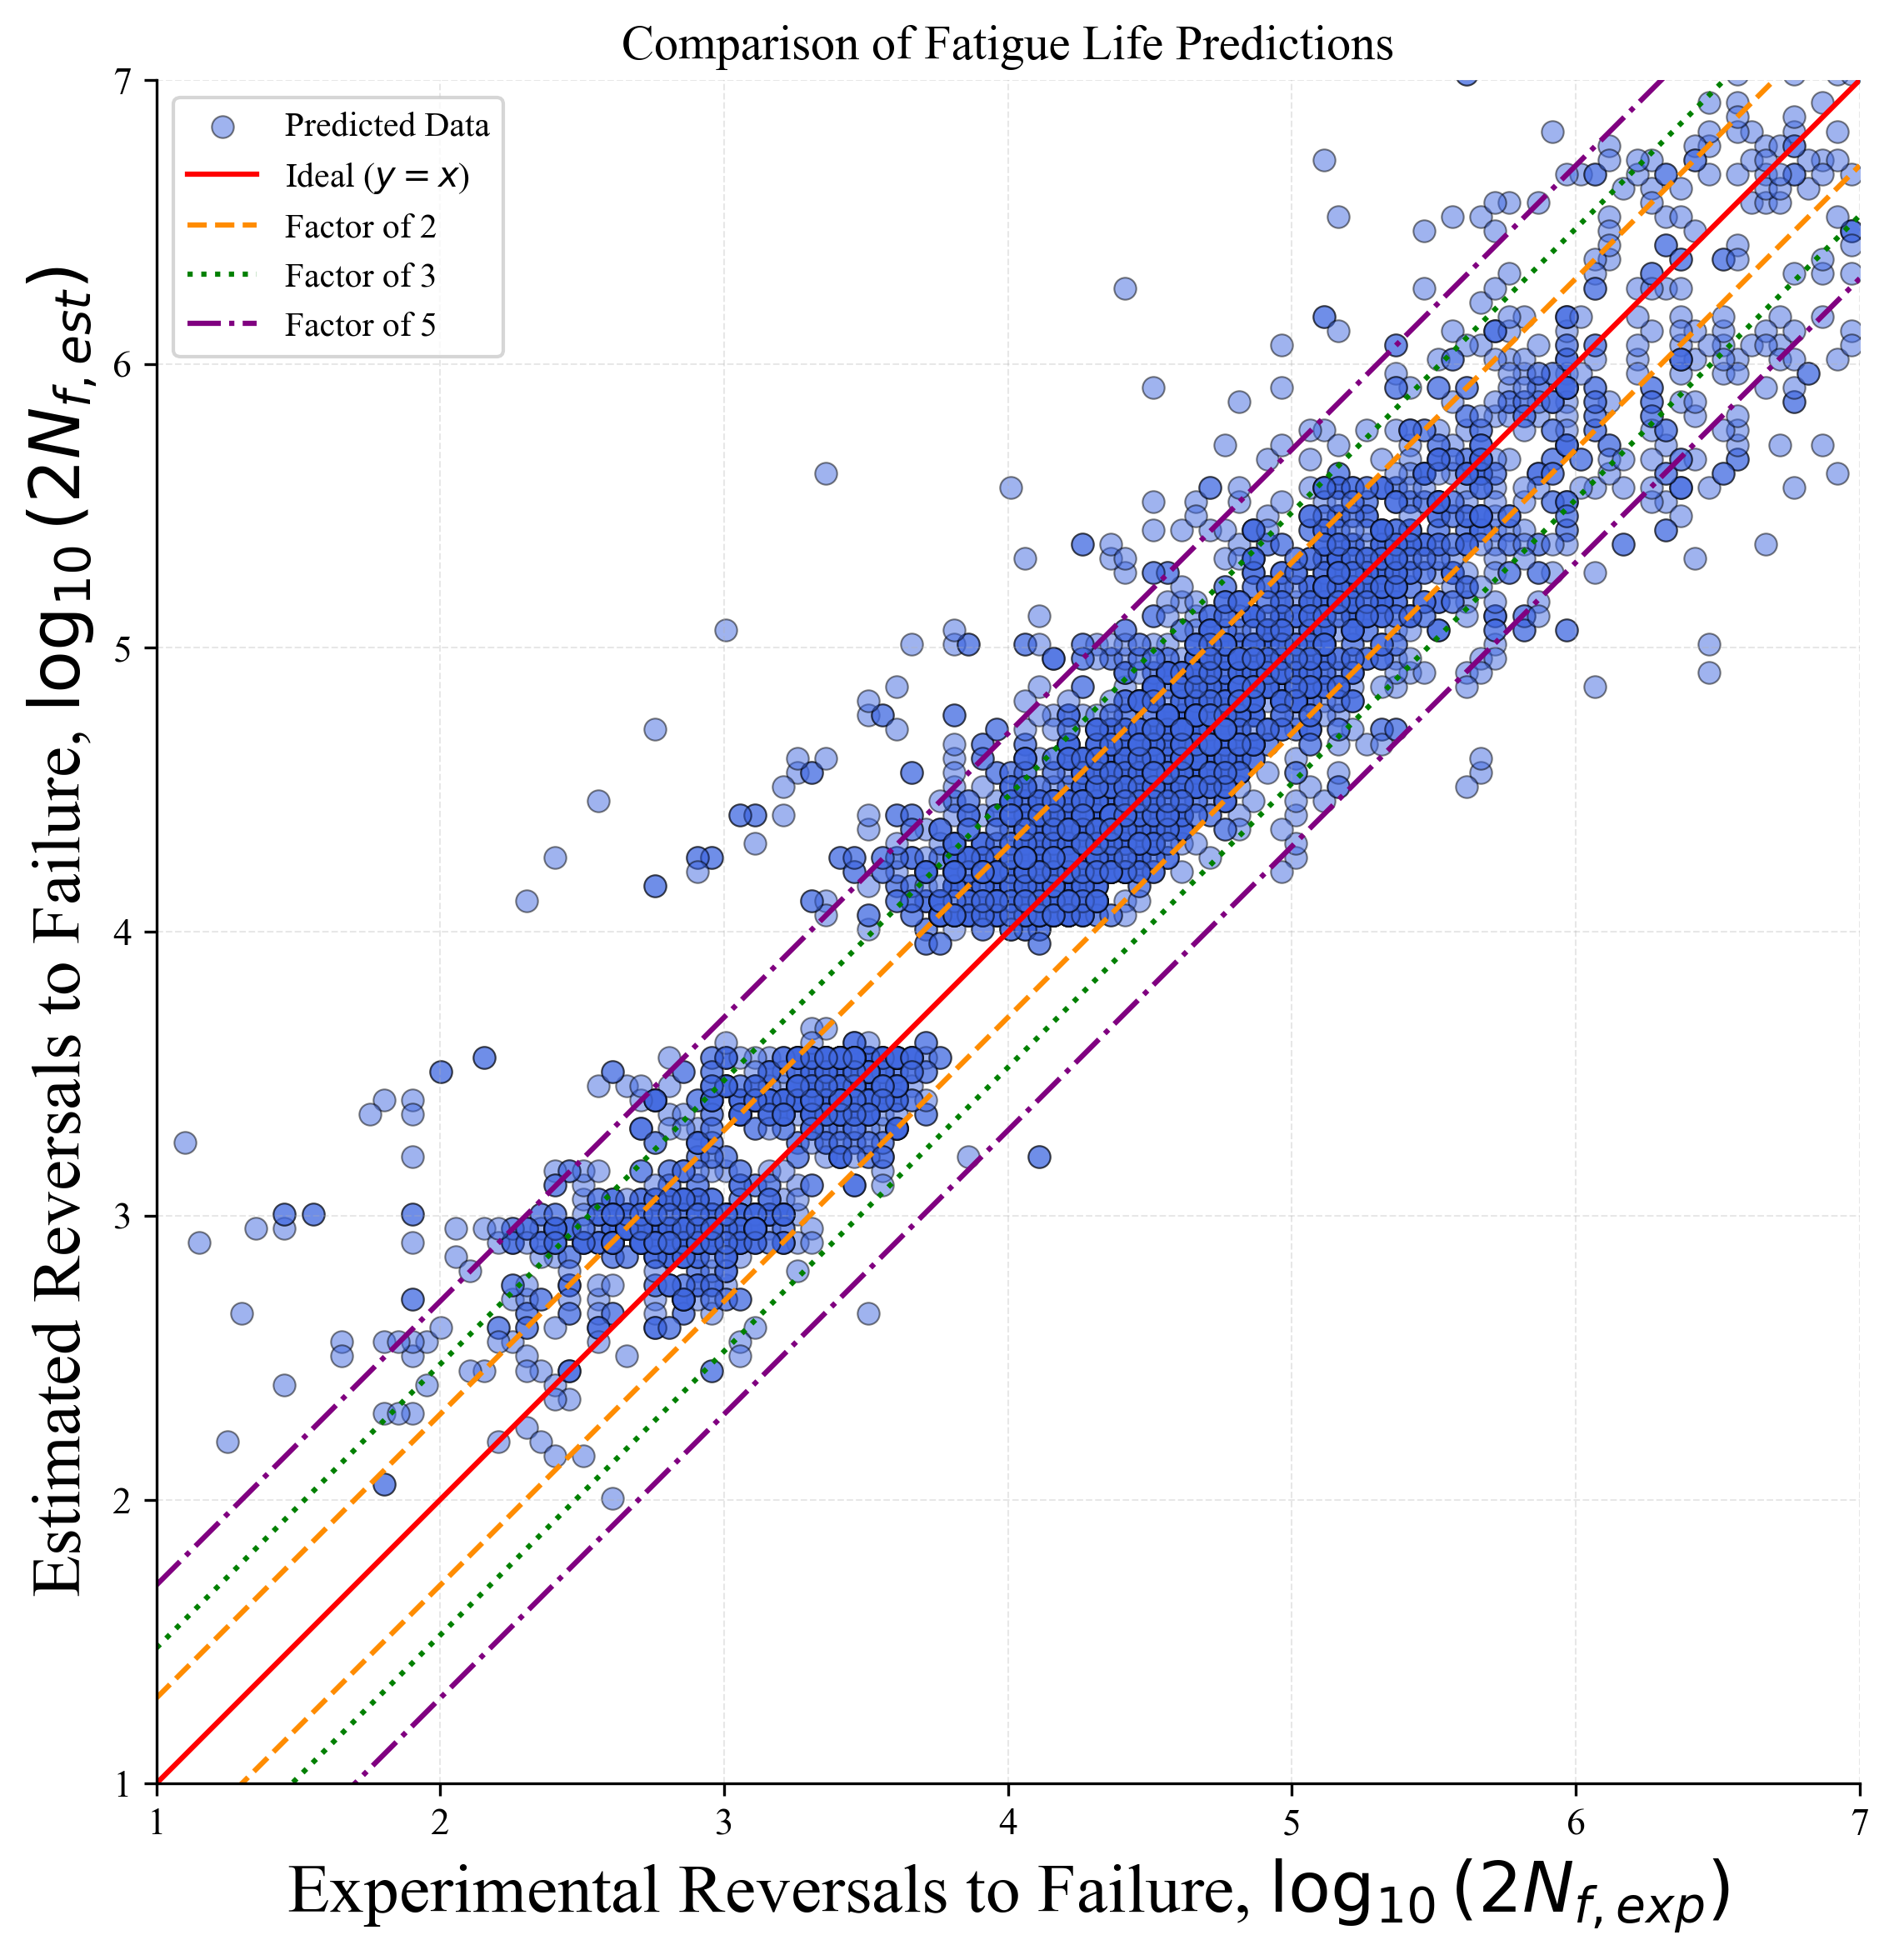

R-squared (on log10 values): 0.8807
Percentage of points within a factor of 2: 79.28%
Percentage of points within a factor of 3: 88.97%
Percentage of points within a factor of 5: 94.71%


In [10]:
# Cell 6: 종합 성능 평가 및 시각화 (참고 코드 스타일 적용)
# =============================================================================

if 'df_results' in locals() and 'spf_MPa_pred' in df_results.columns and not df_results['spf_MPa_pred'].isnull().all():
    print("\nCalculating final fatigue life (2Nf) and visualizing overall performance...")
    
    # --- Font Configuration for Publication Quality ---
    # [수정됨] NameError를 해결하기 위해 'mpl' 대신 'plt'를 사용
    plt.rcParams.update({
        'font.family': 'serif', 'font.serif': 'Times New Roman', 'font.size': 12,
        'axes.labelsize': 20, 'axes.titlesize': 14, 'legend.fontsize': 10,
        'xtick.labelsize': 11, 'ytick.labelsize': 11, 'lines.linewidth': 1.8,
        'axes.grid': True, 'grid.alpha': 0.3, 'figure.dpi': 300,
        'axes.unicode_minus': False
    })
    # ------------------------------------

    # 사용자가 요청한 변형률 진폭 값으로 변경
    defined_total_strain_amplitudes = np.array([
        0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.009, 0.015
    ])
    print(f"Using fixed total strain amplitudes (Δε/2 or ε_a) for evaluation: {defined_total_strain_amplitudes}")
    
    true_params_all = df_results[target_cols].values
    pred_params_all = df_results[pred_cols].values
    E_vals_all = df_results['E_MPa'].values

    twoNf_exp_collected, twoNf_est_collected = [], []
    
    for i in range(len(df_results)):
        params_true = true_params_all[i]
        params_pred = pred_params_all[i]
        E_val = E_vals_all[i]

        if any(np.isnan(params_true)) or any(np.isnan(params_pred)):
            continue
            
        for strain_level in defined_total_strain_amplitudes:
            twoNf_exp = solve_2Nf_from_strain(params_true, E_val, strain_level)
            twoNf_est = solve_2Nf_from_strain(params_pred, E_val, strain_level)

            if not np.isnan(twoNf_exp) and not np.isnan(twoNf_est):
                if 10**1 <= twoNf_exp <= 10**7:
                    twoNf_exp_collected.append(twoNf_exp)
                    twoNf_est_collected.append(twoNf_est)

    # 유효한 데이터가 있는 경우에만 로그 변환 및 플로팅 진행
    if len(twoNf_exp_collected) > 0:
        log_2Nf_exp_final = np.log10(np.array(twoNf_exp_collected))
        log_2Nf_est_final = np.log10(np.array(twoNf_est_collected))
    else:
        log_2Nf_exp_final, log_2Nf_est_final = [], []
    
    print(f"Filtered to {len(log_2Nf_exp_final)} (exp, est) pairs for plotting.")

    # Visualization
    if len(log_2Nf_exp_final) > 1:
        # --- 개선된 플롯 코드 ---
        fig, ax = plt.subplots(figsize=(8, 8), facecolor='none') # 투명한 배경 설정

        # 1. 산점도 (Scatter Plot)
        # 마커를 원형('o')으로, 테두리(edgecolor)를 검은색으로, 투명도(alpha)를 조절하여 데이터 밀도를 표현
        ax.scatter(np.log10(twoNf_exp_collected), np.log10(twoNf_est_collected),
                   marker='o',
                   alpha=0.5,
                   s=40,  # 마커 사이즈
                   color='royalblue', # 차분한 색상
                   edgecolor='black',
                   linewidth=0.5,
                   label='Predicted Data') # 범례용 레이블 추가

        # 2. 기준선 (y=x)
        ax.plot([1, 7], [1, 7], 'r-', linewidth=1.5, label='Ideal ($y=x$)')

        # 3. 오차 범위선 (Scatter Bands)
        factors = [2, 3, 5]
        colors = ['darkorange', 'green', 'purple']
        linestyles = ['--', ':', '-.']

        for i, factor in enumerate(factors):
            log_factor = np.log10(factor)
            ax.plot([1, 7], [1 + log_factor, 7 + log_factor], color=colors[i], linestyle=linestyles[i], linewidth=1.5, label=f'Factor of {factor}')
            ax.plot([1, 7], [1 - log_factor, 7 - log_factor], color=colors[i], linestyle=linestyles[i], linewidth=1.5)

        # 4. 축 레이블 및 제목
        # LaTeX 문법을 사용하여 더 전문적인 레이블 작성 (r'...' 사용)
        ax.set_xlabel(r'Experimental Reversals to Failure, $\log_{10}(2N_{f,exp})$')
        ax.set_ylabel(r'Estimated Reversals to Failure, $\log_{10}(2N_{f,est})$')
        ax.set_title('Comparison of Fatigue Life Predictions')

        # 5. 축 범위 및 눈금
        ax.set_xlim(1, 7)
        ax.set_ylim(1, 7)
        ax.set_xticks(np.arange(1, 8, 1))
        ax.set_yticks(np.arange(1, 8, 1))
        ax.set_aspect('equal', adjustable='box') # 1:1 비율 유지

        # 6. 범례 및 그리드
        ax.legend(loc='upper left')
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

        # 7. 축선(Spines) 설정 (선택사항, 더 깔끔한 디자인을 위해)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # 8. 투명한 배경 설정
        ax.set_facecolor('none')
        fig.patch.set_alpha(0.0)
        ax.patch.set_alpha(0.0)

        # 9. 레이아웃 최적화 및 플롯 표시
        plt.tight_layout()

        # 고해상도 투명 배경의 이미지 파일로 저장하려면 아래 주석을 해제하세요.
        # plt.savefig('Fatigue_Life_Comparison.png', dpi=300, transparent=True, bbox_inches='tight')

        plt.show()

        # --- 통계 정보 출력 (기존과 동일) ---
        r2_val = r2_score(np.log10(twoNf_exp_collected), np.log10(twoNf_est_collected))
        print(f"R-squared (on log10 values): {r2_val:.4f}")

        ratio = np.array(twoNf_est_collected) / np.array(twoNf_exp_collected)
        for factor in [2, 3, 5]:
            within_band = np.sum((ratio >= 1/factor) & (ratio <= factor))
            percentage = (within_band / len(ratio)) * 100
            print(f"Percentage of points within a factor of {factor}: {percentage:.2f}%")

    else:
        print("Not enough valid 2Nf data points were calculated for plotting.")

else:
    print("Could not proceed with visualization because prediction results are not available.")



Calculating final fatigue life (2Nf) and visualizing overall performance...
Using fixed total strain amplitudes (Δε/2 or ε_a) for evaluation: [0.0025 0.003  0.0035 0.004  0.0045 0.005  0.009  0.015 ]
Filtered to 5033 (exp, est) pairs for plotting.


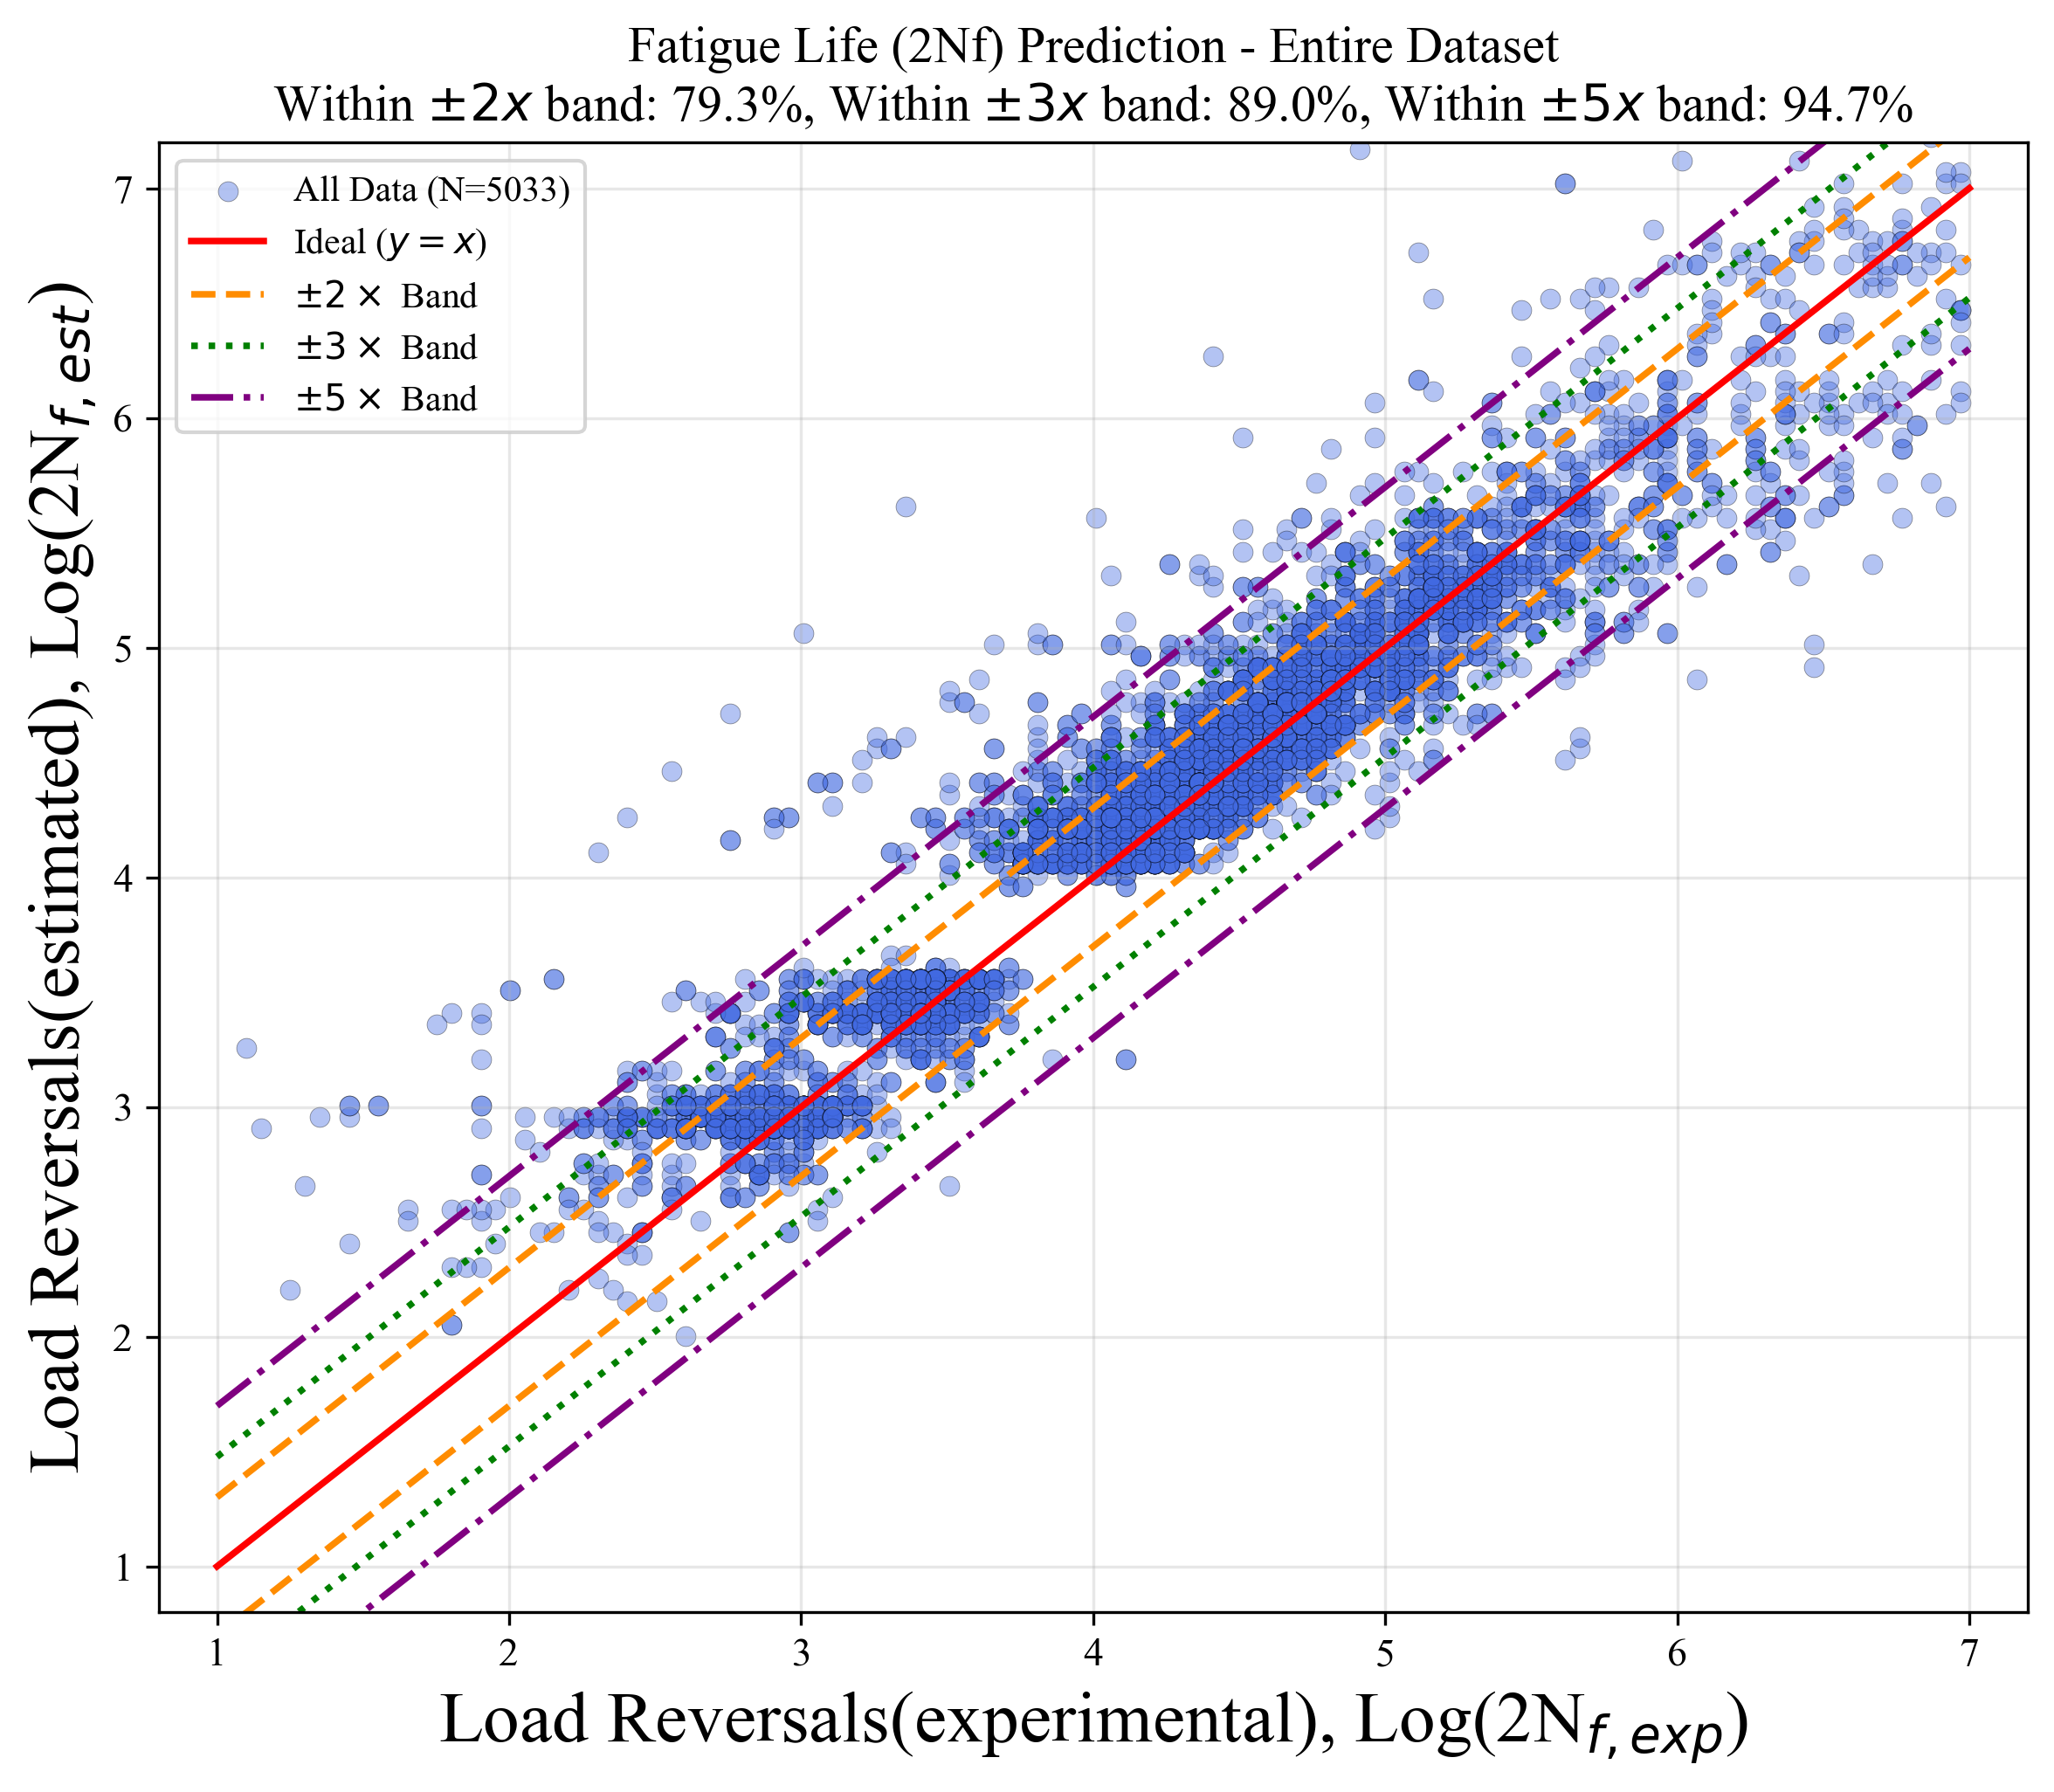


Fatigue Life (log10(2Nf)) R2 Score on Entire Dataset: 0.8807
Percentage of predictions within +/-2x scatter band: 79.28%
Percentage of predictions within +/-3x scatter band: 88.97%
Percentage of predictions within +/-5x scatter band: 94.71%


In [ ]:
# Cell 6-Web: 종합 성능 평가 및 시각화 (참고 코드 스타일 적용)
# =============================================================================

if 'df_results' in locals() and 'spf_MPa_pred' in df_results.columns and not df_results['spf_MPa_pred'].isnull().all():
    print("\nCalculating final fatigue life (2Nf) and visualizing overall performance...")
    
    # --- Font Configuration for Publication Quality ---
    plt.rcParams.update({
        'font.family': 'serif', 'font.serif': 'Times New Roman', 'font.size': 12,
        'axes.labelsize': 20, 'axes.titlesize': 14, 'legend.fontsize': 10,
        'xtick.labelsize': 11, 'ytick.labelsize': 11, 'lines.linewidth': 1.8,
        'axes.grid': True, 'grid.alpha': 0.3, 'figure.dpi': 300,
        'axes.unicode_minus': False
    })
    # ------------------------------------

    defined_total_strain_amplitudes = np.array([
        0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.009, 0.015
    ])
    print(f"Using fixed total strain amplitudes (Δε/2 or ε_a) for evaluation: {defined_total_strain_amplitudes}")
    
    true_params_all = df_results[target_cols].values
    pred_params_all = df_results[pred_cols].values
    E_vals_all = df_results['E_MPa'].values

    twoNf_exp_collected, twoNf_est_collected = [], []
    
    for i in range(len(df_results)):
        params_true = true_params_all[i]
        params_pred = pred_params_all[i]
        E_val = E_vals_all[i]

        if any(np.isnan(params_true)) or any(np.isnan(params_pred)):
            continue
            
        for strain_level in defined_total_strain_amplitudes:
            twoNf_exp = solve_2Nf_from_strain(params_true, E_val, strain_level)
            twoNf_est = solve_2Nf_from_strain(params_pred, E_val, strain_level)

            if not np.isnan(twoNf_exp) and not np.isnan(twoNf_est):
                if 10**1 <= twoNf_exp <= 10**7:
                    twoNf_exp_collected.append(twoNf_exp)
                    twoNf_est_collected.append(twoNf_est)

    # 유효한 데이터가 있는 경우에만 로그 변환 및 플로팅 진행
    if len(twoNf_exp_collected) > 0:
        log_2Nf_exp_final = np.log10(np.array(twoNf_exp_collected))
        log_2Nf_est_final = np.log10(np.array(twoNf_est_collected))
    else:
        log_2Nf_exp_final, log_2Nf_est_final = [], []
    
    print(f"Filtered to {len(log_2Nf_exp_final)} (exp, est) pairs for plotting.")

    # Visualization
    if len(log_2Nf_exp_final) > 1:
        plt.figure(figsize=(8, 7), facecolor='none')
        ax = plt.gca()
        
        r2_2Nf_final = r2_score(log_2Nf_exp_final, log_2Nf_est_final)
        ratio_2Nf_final = np.array(twoNf_est_collected) / np.array(twoNf_exp_collected)
        
        inside_2x_final = np.mean((ratio_2Nf_final >= 1/2) & (ratio_2Nf_final <= 2)) * 100
        inside_3x_final = np.mean((ratio_2Nf_final >= 1/3) & (ratio_2Nf_final <= 3)) * 100
        inside_5x_final = np.mean((ratio_2Nf_final >= 1/5) & (ratio_2Nf_final <= 5)) * 100

        ax.scatter(log_2Nf_exp_final, log_2Nf_est_final, alpha=0.4, s=30, 
                   color='royalblue', edgecolor='k', linewidth=0.2, label=f'All Data (N={len(log_2Nf_exp_final)})')
        
        plot_axis_min_log = 1.0
        plot_axis_max_log = 7.0
        line_vals_log = np.array([plot_axis_min_log, plot_axis_max_log])

        ax.plot(line_vals_log, line_vals_log, 'r-', label='Ideal ($y=x$)')
        
        log_factor_2 = np.log10(2.0)
        log_factor_3 = np.log10(3.0)
        log_factor_5 = np.log10(5.0)
        
        ax.plot(line_vals_log, line_vals_log + log_factor_2, color='darkorange', linestyle='--', label=r'$\pm 2\times$ Band')
        ax.plot(line_vals_log, line_vals_log - log_factor_2, color='darkorange', linestyle='--')
        
        ax.plot(line_vals_log, line_vals_log + log_factor_3, color='green', linestyle=':', label=r'$\pm 3\times$ Band')
        ax.plot(line_vals_log, line_vals_log - log_factor_3, color='green', linestyle=':')
        
        ax.plot(line_vals_log, line_vals_log + log_factor_5, color='purple', linestyle='-.', label=r'$\pm 5\times$ Band')
        ax.plot(line_vals_log, line_vals_log - log_factor_5, color='purple', linestyle='-.')

        ax.set_xlabel('Load Reversals(experimental), Log(2N$_{f,exp}$)')
        ax.set_ylabel('Load Reversals(estimated), Log(2N$_{f,est}$)')
        
        title_text = (f'Fatigue Life (2Nf) Prediction - Entire Dataset\n'
                      f'Within $\\pm 2x$ band: {inside_2x_final:.1f}%, '
                      f'Within $\\pm 3x$ band: {inside_3x_final:.1f}%, '
                      f'Within $\\pm 5x$ band: {inside_5x_final:.1f}%')
        ax.set_title(title_text)
        
        ax.set_xlim(plot_axis_min_log - 0.2, plot_axis_max_log + 0.2)
        ax.set_ylim(plot_axis_min_log - 0.2, plot_axis_max_log + 0.2)
        
        tick_values = np.arange(int(np.floor(plot_axis_min_log)), int(np.ceil(plot_axis_max_log)) + 1, 1.0)
        ax.set_xticks(tick_values)
        ax.set_yticks(tick_values)
        
        ax.legend(frameon=True, loc='upper left')
        ax.set_facecolor('none')

        plt.tight_layout()
        plt.show()
        
        print(f"\nFatigue Life (log10(2Nf)) R2 Score on Entire Dataset: {r2_2Nf_final:.4f}")
        print(f"Percentage of predictions within +/-2x scatter band: {inside_2x_final:.2f}%")
        print(f"Percentage of predictions within +/-3x scatter band: {inside_3x_final:.2f}%")
        print(f"Percentage of predictions within +/-5x scatter band: {inside_5x_final:.2f}%")

    else:
        print("Not enough valid 2Nf data points were calculated for plotting.")

else:
    print("Could not proceed with visualization because prediction results are not available.")
